In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  



sys.path.append('/Users/kemran/Desktop/work_files/python_files') 
from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [9]:
query = f'''
    SELECT 
    ends_at,
    user_id,
    recurrent,
    renewal_off_date,
    reg_source,
    device,
    free_days,
    created_at::date AS trial_date,
    CASE WHEN first_prolong_date!='1970-01-01' THEN 'subs' ELSE 'trial' END AS trial_subs_type
    FROM datamarts.marketing_dash
    WHERE created_at!='1970-01-01' AND ends_at BETWEEN now() AND now() + INTERVAL '14' day
    AND state!='canceled' AND promo_type!='cards' AND recurrent=TRUE AND renewal_off_date='1970-01-01'
'''
df = execute(query,user='kmekhtiev')

df['ends_at'] = pd.to_datetime(df['ends_at'])
df['trial_date'] = pd.to_datetime(df['trial_date'])

Время выполнения функции: 1.3805 секунд



In [13]:
df['ends_at'].max()

Timestamp('2025-04-07 00:00:00')

In [15]:
df['trial_subs_type'].value_counts()

trial_subs_type
trial    3231
subs     1870
Name: count, dtype: int64

In [19]:
import hashlib

def get_user_bucket(df, salt, num_of_group):
    df['hash_object'] = df['user_id'].apply(lambda x:hashlib.sha256(f"{x}:{salt}".encode()))
    df['hash_int'] = df['hash_object'].apply(lambda x: int(x.hexdigest(),16))
    df['bucket'] = df['hash_int'].apply(lambda x: x % 10000 / 10000.0)
    if num_of_group == 2:
        df['test_group'] = df['bucket'].apply(lambda x:'group_a' if x<0.5 else 'group_b')
    elif num_of_group == 3:
        df['test_group'] = df['bucket'].apply(lambda x:
            'group_a' if x<=0.33 else
            'group_b' if x<=0.66 else
            'group_c'
        )
    elif num_of_group == 4:
        df['test_group'] = df['bucket'].apply(lambda x:
            'group_a' if x<=0.25 else
            'group_b' if x<=0.5 else
            'group_c' if x<=0.75 else
            'group_d'
        )
    return df

In [21]:
get_user_bucket(df,salt='backend_test',num_of_group = 2)

,ends_at,user_id,recurrent,renewal_off_date,reg_source,device,free_days,trial_date,trial_subs_type,hash_object,hash_int,bucket,test_group
0,2025-03-28,91999bbc-ef3f-4a3d-9f39-1f44bc2cf105,true,1970-01-01,none,web,14,2024-08-16,subs,<sha256 _hashlib.HASH object @ 0x14e83b070>,1021747226999316085126533486399329366588148693...,0.5788,group_b
1,2025-04-07,80a0bc82-c9fa-4ea7-9c2f-6245e2e4a80e,true,1970-01-01,none,web,14,2024-06-07,subs,<sha256 _hashlib.HASH object @ 0x14e83a970>,4165204290721609209601481814199428930402977375...,0.9723,group_b
2,2025-03-25,98eb9b1d-f9b9-4832-af44-a00a3a26f7be,true,1970-01-01,google-play,android,14,2024-01-11,subs,<sha256 _hashlib.HASH object @ 0x14e83a150>,1082556862374368805237836131333445583201363859...,0.3791,group_a
3,2025-03-31,d0a1a6cd-0154-47ce-bb5f-e8383a6dda4d,true,1970-01-01,google-play,android,35,2025-02-24,trial,<sha256 _hashlib.HASH object @ 0x14e83aa70>,4199843081902771067177041224166083740109456055...,0.6403,group_b
4,2025-04-03,8504bf4d-9dc3-4266-9e67-7e427a145c1d,true,1970-01-01,none,web,45,2024-08-19,subs,<sha256 _hashlib.HASH object @ 0x14e83a990>,5993898211488713543002765653812306392062622875...,0.7591,group_b
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5096,2025-04-02,35a4b152-4e09-4c6b-844e-db8119872aee,true,1970-01-01,none,web,35,2024-07-29,subs,<sha256 _hashlib.HASH object @ 0x14e9b7030>,4228177158809223532717412245575284915300542813...,0.8961,group_b
5097,2025-04-02,11a27534-e633-4478-a4a6-d020d5e02ea5,true,1970-01-01,none,web,35,2024-07-29,subs,<sha256 _hashlib.HASH object @ 0x14e9b7050>,2409551913576309015244014740114743480258147535...,0.5825,group_b
5098,2025-03-25,ba5ec4c4-e647-4d93-a18c-cdc89addde59,true,1970-01-01,none,web,45,2024-08-11,subs,<sha256 _hashlib.HASH object @ 0x14e9b7070>,1114024268589704628310194616224240876937510118...,0.3566,group_a
5099,2025-04-07,23ae4ef5-8608-44e0-86c0-405ae9b75e51,true,1970-01-01,none,web,35,2025-03-03,trial,<sha256 _hashlib.HASH object @ 0x14e9b7090>,2786770037535148704138073091783895540702929566...,0.8192,group_b


In [23]:
def plot_segments_distribution(df, segment_columns, test_factor):
    for i in segment_columns:
        aggregated_data = df.groupby(by = [test_factor,i])['user_id'].count().reset_index()
        sns.catplot(x = i, 
                    y = 'user_id', 
                    hue = test_factor, # сообщаем, что хотим, чтобы разные группы имели разный цвет
                    data = aggregated_data.sort_values(by='user_id', ascending=False).iloc[:40], 
                    kind = "bar", 
                    height = 4,
                    aspect = 1.5)
        plt.xticks(rotation=100)

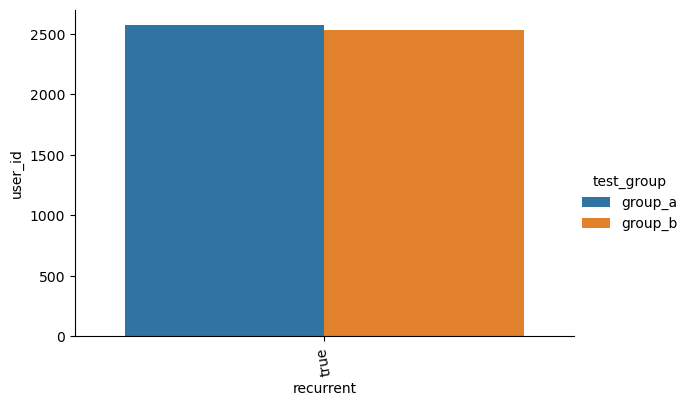

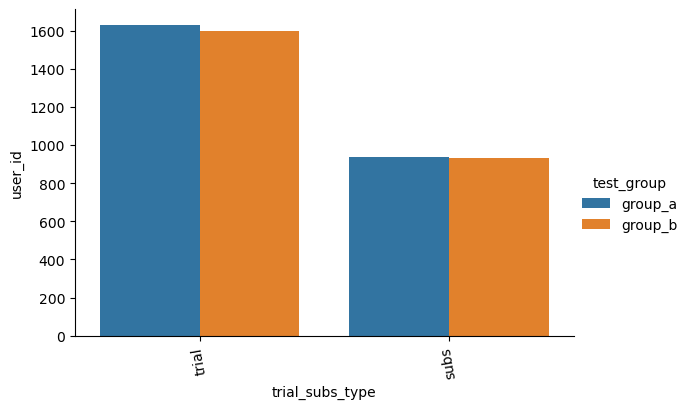

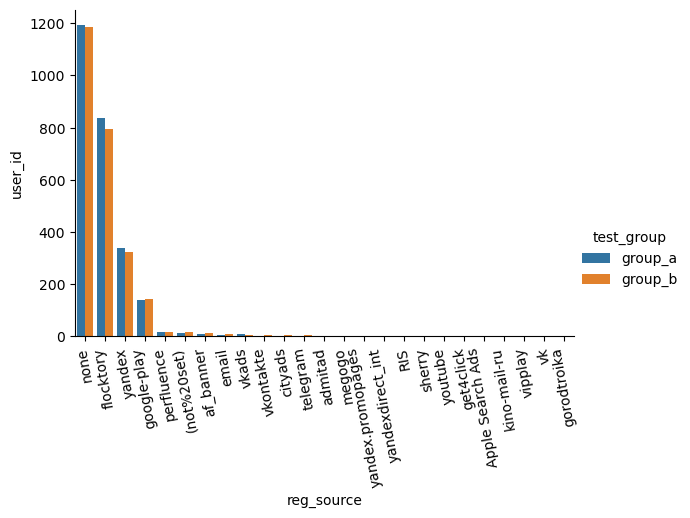

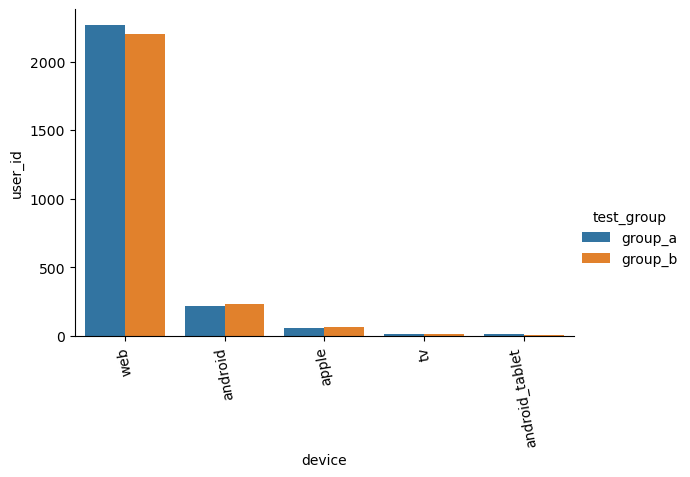

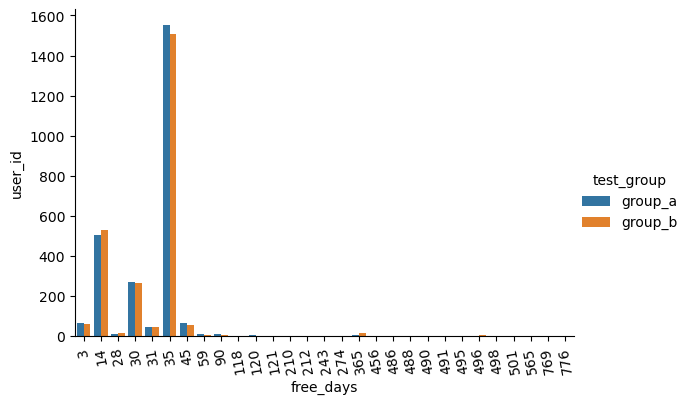

In [25]:
plot_segments_distribution(df,['recurrent','trial_subs_type','reg_source','device','free_days'],"test_group")

In [35]:
df[df['test_group']=='group_b']['user_id'].to_csv('group_b_test_ids.csv',index=False)

In [40]:
pd.read_csv('group_b_test_ids.csv')

,user_id
0,91999bbc-ef3f-4a3d-9f39-1f44bc2cf105
1,80a0bc82-c9fa-4ea7-9c2f-6245e2e4a80e
2,d0a1a6cd-0154-47ce-bb5f-e8383a6dda4d
3,8504bf4d-9dc3-4266-9e67-7e427a145c1d
4,35c832f5-e24a-44ab-af02-75264e79e2f0
...,...
2525,ea0ee9bb-8756-4097-adf8-e92703576c47
2526,35a4b152-4e09-4c6b-844e-db8119872aee
2527,11a27534-e633-4478-a4a6-d020d5e02ea5
2528,23ae4ef5-8608-44e0-86c0-405ae9b75e51


In [42]:
df[df['test_group']=='group_b']['user_id'].to_csv('group_b_test_ids.csv',index=False)

In [58]:
df[df['test_group']=='group_a']['user_id'].to_csv('group_a_control_ids.csv',index=False)